# Capstone: Number transcription from images
### Preprocess

Goal is to recognize and transcribe numbers of varying length from real-world images.

In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import misc
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
import random
import pprint
import cv2


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First download the SVHN dataset, format 1, which contains 73257 digits for training, 26032 digits for testing and 531131 extra images which less difficult samples.

In [5]:
# format 1
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)


('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


Extract the contents of the download files.

In [6]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  print "Done."
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
Done.
test already present - Skipping extraction of test.tar.gz.
Done.
extra already present - Skipping extraction of extra.tar.gz.
Done.


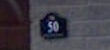

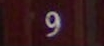

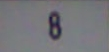

In [7]:
## visual exploration
for i in range(5):
    img = ('test/' + os.listdir(test_folder)[i])
    display(Image(img))


Extract the name and bbox arrays from the .mat files.

https://www.getdatajoy.com/learn/Read_and_Write_HDF5_from_Python

In [8]:
## test for pickle files, if they exist skip several steps
create_all = True

def test_pickles(pickleName, force = False):
    pExists = False
    if os.path.isfile(pickleName) and not force:
        pExists = True
    print pickleName, "exists:", pExists
    return pExists

test_pickle = test_pickles("testPickle/test_dataset.pickle", force = False)
train_pickle = test_pickles("trainPickle/train_dataset.pickle", force = False)
extra_pickle = test_pickles("extraPickle/extra_dataset1.pickle", force = False)

if test_pickle and train_pickle and extra_pickle:
    create_all = False
    
print "\nCreating all pickle files:", create_all

testPickle/test_dataset.pickle exists: True
trainPickle/train_dataset.pickle exists: True
extraPickle/extra_dataset1.pickle exists: True

Creating all pickle files: False


In [9]:
mat_name = 'digitStruct.mat'

def get_mat_contents(folder, matfile):
    # call in .mat file format 1

    matfile = os.path.join(folder, matfile)
    f = h5py.File(matfile,'r')
    print f
    group = f.get('digitStruct')
    print group
    data = group.items()
    print data
    name = group.get('name')
    name_arr = np.array(name)
    print 'Name shape:', name_arr.shape
    bbox = group.get('bbox')
    bbox_arr = np.array(bbox)
    print 'bbox shape:', bbox_arr.shape
    print '\n'
    return f, name_arr, bbox_arr

if create_all:
    test_f, test_name_arr, test_bbox_arr = get_mat_contents('test', mat_name)
    train_f, train_name_arr, train_bbox_arr = get_mat_contents('train', mat_name)
    extra_f, extra_name_arr, extra_bbox_arr = get_mat_contents('extra', mat_name)


In [10]:
### create np.ndarray that will contain the image file names from .mat file data

def create_array(array, data_type, d2=0, d3=0):
    if d2 == 0:
        empty_array = np.zeros((array.shape[0], 1), data_type)
    else:
        empty_array = np.zeros((array.shape[0], d2, d3), data_type)
    return empty_array


def create_name_array(f, name_arr):
    img_array = create_array(name_arr, data_type=object)
    
    for index in range(name_arr.shape[0]):
        n_img = f[name_arr[index][0]]
        n_arr = np.array(n_img)

        text = ""
        for i in range(len(n_arr)):
            num = n_arr[i][0]
            char = chr(num)
            text += char
        img_array[index,0] = text
    print "Name Shape: {}".format(img_array.shape)
    return img_array

if create_all:
    test_img_array = create_name_array(test_f, test_name_arr)
    train_img_array = create_name_array(train_f, train_name_arr)
    extra_img_array = create_name_array(extra_f, extra_name_arr)

    print "\nTest images sample: \n{}".format(test_img_array[:5])

The bbox arrays are 3 dimensional arrays in the shape (n, 6, 5). N being the number of images in the file. 

The 5 columns define the bounding box of each digit in the image and its corresponding label. The current (default) labels are 1-10, where label 10 = 0, label 1 = 1, label 2 = 2 as so on. 

The columns are in the order as follows: height, label, left, top and width.

In [11]:
## Please note this step will take a while: 10 mins+

address_len = 6
bbox_dims = 5

def create_bbox_array(f, bbox_arr):
    bbox_ndarray = create_array(bbox_arr, np.int32, d2=address_len, d3=bbox_dims)
    print 'Bounding box shape: {}'.format(bbox_ndarray.shape)
    
    for index in range(bbox_arr.shape[0]):
        b_img = f[bbox_arr[index][0]]
        dsets = b_img.items()
        #print b_img
        #print dsets

        name_list = []
        for name in dsets:
            dname = name[0]
            name_list.append(dname)
        #print '\n',name_list

        for i,v in enumerate(name_list):
            dataset = b_img.get(v)
            dataset_arr = np.array(dataset)
            for j in range(len(dataset_arr)):
                ref = dataset_arr[j][0]
                if len(dataset_arr) == 1:
                    bbox_ndarray[index,j,i] = ref
                    #print 'img{}-{},digit{}: {}'.format(index,v,j,ref)
                else:
                    d = b_img[ref]
                    dp = np.array(d)[0][0]
                    bbox_ndarray[index,j,i] = dp
                    #print 'img{}-{},digit{}: {}'.format(index,v,j,dp)
    return bbox_ndarray, name_list

if create_all:
    test_bbox_ndarray, colNames = create_bbox_array(test_f, test_bbox_arr)
    train_bbox_ndarray, colNames = create_bbox_array(train_f, train_bbox_arr)
    extra_bbox_ndarray, colNames = create_bbox_array(extra_f, extra_bbox_arr)

    print "\nColumn Names: \n{}\n".format(colNames)
    print "\nFirst 5 test bounding boxes: \n{}".format(test_bbox_ndarray[:5])

In [12]:
## crop images to all bboxes + 30%
# resize to 64x64
# add to ndarray
# 630,420 images total, images could be up to 300 kb. 


############    make this function happen and maybe pickle   #############
def crop_img(img_file, img_index, bbox_array):
    ## call in the image
    arr = bbox_array[img_index]
    #print "start array:", arr.shape
    #print arr
    expand = 0.3 # 30%

    ## remove rows with zeros
    arr0 = arr[np.nonzero(arr)]
    #print "non-zero array:", arr0.shape
    #print arr0
    arr0 = arr0.reshape(len(arr0)/5,5)
    #print "Column Names: \n{}\n".format(colNames)
    #print "Img crop dims: \n{}\n".format(arr0)

    img = ndimage.imread(img_file, flatten=True)

    ## crop the image to the sum of all the bounding boxes, i.e. all digits in one image
    y_top = np.min(arr0[:,3])
    x_left = np.min(arr0[:,2])
    height = np.max(arr0[:,0])
    width = np.sum(arr0[:,4])
    #print "Before expand 30%: {}, {}, {}, {}".format(y_top, x_left, height, width)
    height_expand = int((height * expand)/2)
    width_expand = int((width * expand)/2)
    y_top = y_top - height_expand
    x_left = x_left - width_expand
    height = height + height_expand
    width = width + width_expand
    #print "After expand 30%: {}, {}, {}, {}".format(y_top, x_left, height, width)
    crop_img = img[y_top:y_top + height, x_left:x_left + width]
    #resize_img = cv2.resize(crop_img, (64,64))
    
    ## display the original cropped image and the resized image
    #plt.imshow(crop_img)
    #plt.show()
    #plt.imshow(resize_img)
    #plt.show()
    
    return crop_img


In [13]:
## convert resized image to ndarray
image_size = 64
pixel_depth = 255.0

def load_letter(folder, bbox_array, img_array):
    image_files = img_array
    dataset = np.zeros(shape=(len(image_files), image_size, image_size),
                             dtype=np.float32)
    print folder
    num_images = 0
    num_errors = 0
    for image in image_files:
        image = image[0]
        try: 
            #print "Pic file: {}".format(image)
            image_file = os.path.join(folder, image)
            cropped_image = crop_img(image_file, num_images, bbox_array)
            image_data = np.array(cropped_image, dtype=float)
            #print image_data.shape
            #print image_data
            resized_image_data = misc.imresize(image_data, (64, 64))
            normalized_image = (resized_image_data - pixel_depth / 2) \
                                / (pixel_depth/2.0)
            dataset[num_images, :, :] = normalized_image
        except ValueError as e:
            print "Error reading image: {}. Ok, we'll skip it.".format(image)
            num_errors += 1
        num_images += 1
    print 'Number of images not loaded:', num_errors
            
    return dataset



In [14]:
def remove_NAs(data, bbox_array):
    nonZero_indices = np.unique(np.nonzero(data)[0])
    data = data[nonZero_indices]
    labels = bbox_array[nonZero_indices]
    labels = labels[:, :, 1]
    
    return data, labels

In [15]:
# put length of the digit sequence as the first number
# add label 11 as a blank, 0 to 9 and 11 (10 classes total)
# convert label 10 to 0, so that 0=0, 1=1 and so on

def format_labels(label_arr):
    # shift the array so the first value contains a 0, to be updated to length
    labels = np.roll(label_arr, 1, axis=1)
    
    # put the length of the digit sequence in the first position
    for seq in labels:
        seq[0] = np.count_nonzero(seq)
    
    # make 11 the new blank (replaces 0), and covert 10 to 0 (this way 0=0)
    for digit in np.nditer(labels, op_flags=['readwrite']):
        if digit == 0:
            digit[...] = 11
        if digit == 10:
            digit[...] = 0
    
    return labels

In [16]:
currPath = os.getcwd()

def maybe_pickle(folder, bbox_array, img_array, force=False, extra_name=""):
    set_dataset_filename = folder + "Pickle/" + folder + '_dataset' + extra_name + '.pickle'
    set_labels_filename = folder + "Pickle/" + folder + '_labels'+ extra_name + '.pickle'
    
    if os.path.exists(set_dataset_filename) and os.path.exists(set_labels_filename) \
                                            and not force:
        # You may override by setting force=True.
        print '{} and {} already present - Skipping pickling.'.format(set_dataset_filename,
                                                                     set_labels_filename)
    else:
        print 'Pickling {} and {}.'.format(set_dataset_filename, set_labels_filename)
        dataset = load_letter(folder, bbox_array, img_array)
        dataset, labels = remove_NAs(dataset, bbox_array)
        labels = format_labels(labels)
        path = currPath + "/" + folder + "Pickle"
        if not os.path.exists(path):
            os.makedirs(path)
        try:
            with open(set_dataset_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            with open(set_labels_filename, 'wb') as f:
                pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_dataset_filename, ':', e)
        
        print 'NonZero dataset shape:', dataset.shape
        print 'Mean:', np.mean(dataset)
        print 'Standard deviation:', np.std(dataset)
        print 'NonZero label shape:', labels.shape
        
    return set_dataset_filename, set_labels_filename



In [17]:
if create_all:
    test_dataset_name, test_labels_name = maybe_pickle(test_folder, test_bbox_ndarray, \
                                             test_img_array)

In [18]:
if create_all:
    train_dataset_name, train__labels_name = maybe_pickle(train_folder, train_bbox_ndarray, \
                                             train_img_array)

In [19]:
## Please note this step will take a while: 5 mins+
if create_all:
    amt = len(extra_bbox_ndarray)/3
    extra_bbox_ndarray1 = extra_bbox_ndarray[:amt]
    extra_img_array1 = extra_img_array[:amt]
    extra_dataset1_name, extra_labels1_name = maybe_pickle(extra_folder, extra_bbox_ndarray1, \
                                             extra_img_array1, extra_name="1")

    extra_bbox_ndarray2 = extra_bbox_ndarray[amt:2*amt]
    extra_img_array2 = extra_img_array[amt:2*amt]
    extra_dataset2_name, extra_labels2_name = maybe_pickle(extra_folder, extra_bbox_ndarray2, \
                                             extra_img_array2, extra_name="2")

    extra_bbox_ndarray3 = extra_bbox_ndarray[2*amt:]
    extra_img_array3 = extra_img_array[2*amt:]
    extra_dataset3_name, extra_labels3_name = maybe_pickle(extra_folder, extra_bbox_ndarray3, \
                                             extra_img_array3, extra_name="3")

In [20]:
## read in the pickle files
test_dataset_name = "test_dataset.pickle"
test_labels_name = "test_labels.pickle"
train_dataset_name = "train_dataset.pickle"
train_labels_name = "train_labels.pickle"
extra_dataset1_name = "extra_dataset1.pickle"
extra_dataset2_name = "extra_dataset2.pickle"
extra_dataset3_name = "extra_dataset3.pickle"
extra_labels1_name = "extra_labels1.pickle"
extra_labels2_name = "extra_labels2.pickle"
extra_labels3_name = "extra_labels3.pickle"

test_dataset = pickle.load(open("testPickle/" + test_dataset_name, "rb" ))
test_labels = pickle.load(open("testPickle/" + test_labels_name, "rb" ))

train_dataset = pickle.load(open("trainPickle/" + train_dataset_name, "rb" ))
train_labels = pickle.load(open("trainPickle/" + train_labels_name, "rb" ))

extra_dataset1 = pickle.load(open("extraPickle/" + extra_dataset1_name, "rb" ))
extra_labels1 = pickle.load(open("extraPickle/" + extra_labels1_name, "rb" ))

extra_dataset2 = pickle.load(open("extraPickle/" + extra_dataset2_name, "rb" ))
extra_labels2 = pickle.load(open("extraPickle/" + extra_labels2_name, "rb" ))

extra_dataset3 = pickle.load(open("extraPickle/" + extra_dataset3_name, "rb" ))
extra_labels3 = pickle.load(open("extraPickle/" + extra_labels3_name, "rb" ))

extra_dataset = np.concatenate((extra_dataset1,extra_dataset2,extra_dataset3), axis=0)
extra_labels = np.concatenate((extra_labels1,extra_labels2,extra_labels3), axis=0)

print "Extra dataset shape:", extra_dataset.shape
print "Extra labels shape:", extra_labels.shape

testSize = test_labels.shape[0]
trainSize = train_labels.shape[0]
extraSize1 = extra_labels1.shape[0]
extraSize2 = extra_labels2.shape[0]
extraSize3 = extra_labels3.shape[0]
extraSize = extra_labels.shape[0]

print "\nTotal test images:", testSize
print "Total train images:", trainSize
print "Total extra images:", extraSize
print "    Total extra1 images:", extraSize1
print "    Total extra2 images:", extraSize2
print "    Total extra3 images:", extraSize3

# clear original data sets from memory
extra_dataset1 = None
extra_labels1 = None

extra_dataset2 = None
extra_labels2 = None

extra_dataset3 = None
extra_labels3 = None

Extra dataset shape: (144106, 64, 64)
Extra labels shape: (144106, 6)

Total test images: 12525
Total train images: 25330
Total extra images: 144106
    Total extra1 images: 48242
    Total extra2 images: 48007
    Total extra3 images: 47857


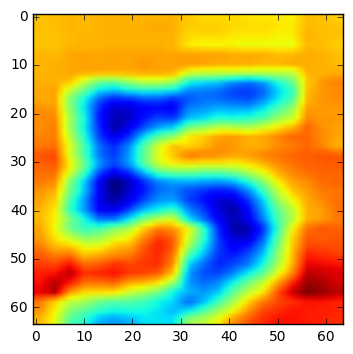

Label: [ 1  5 11 11 11 11]




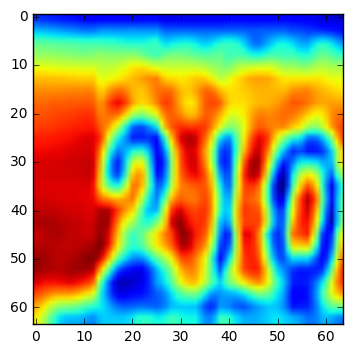

Label: [ 3  2  1  0 11 11]




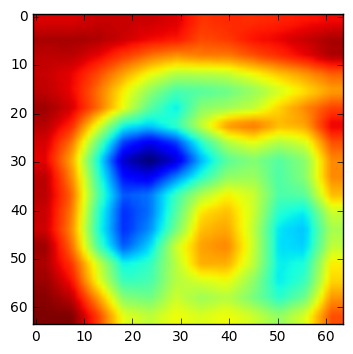

Label: [ 1  6 11 11 11 11]




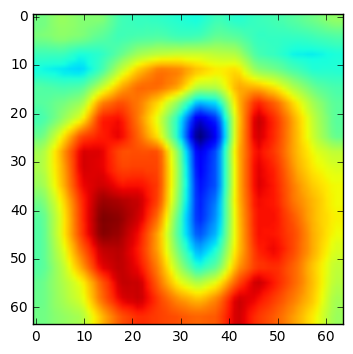

Label: [ 1  1 11 11 11 11]




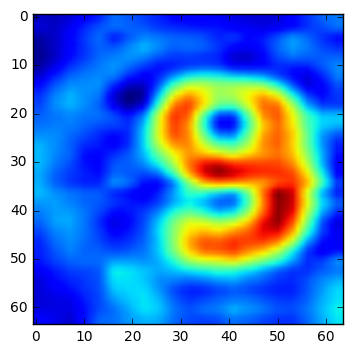

Label: [ 1  9 11 11 11 11]




In [21]:
# check to make sure the data still looks good & compare to its label

for index in range(5):
    picindex = test_dataset[index]
    plt.imshow(picindex)
    plt.show()
    print 'Label: {}\n\n'.format(test_labels[index])

In [22]:
# merge datasets and create validation set
validationSize = 6000
np.random.seed(42)

# half of the validation set is coming from the Training data set and the other half from the Extra data set
if validationSize%2 == 0:
    validSize_fromTraining = validationSize/2
else:
    validSize_fromTraining = (validationSize/2)+1

validSize_fromExtra = validationSize/2

# choose the random indices from the Training set and Extra set for the validation set
randValid_fromTraining = np.random.randint(trainSize, size=validSize_fromTraining)
randValid_fromExtra = np.random.randint(extraSize, size=validSize_fromExtra)

# find remaining indices from the Training and Extra sets not used in the validation set
# this will build the final training data set
randTrain_fromTraining = np.array([i for i in np.arange(trainSize) if i not in randValid_fromTraining])
randTrain_fromExtra = np.array([j for j in np.arange(extraSize) if j not in randValid_fromExtra])

# create the 2 validation data sets and 2 label sets and then concatenate into 1 array for the data set and labels
valid_dataset_fromTrain = train_dataset[randValid_fromTraining]
valid_dataset_fromExtra = extra_dataset[randValid_fromExtra]
valid_labels_fromTrain = train_labels[randValid_fromTraining]
valid_labels_fromExtra = extra_labels[randValid_fromExtra]

valid_dataset = np.concatenate((valid_dataset_fromTrain,valid_dataset_fromExtra),axis=0)
valid_labels = np.concatenate((valid_labels_fromTrain,valid_labels_fromExtra),axis=0)

valid_dataset_fromTrain = None
valid_dataset_fromExtra = None
valid_labels_fromTrain = None
valid_labels_fromExtra = None

# create the final training data set from the remaining images not used in the validation set
train_dataset_fromTrain = train_dataset[randTrain_fromTraining]
train_dataset_fromExtra = extra_dataset[randTrain_fromExtra]
train_labels_fromTrain = train_labels[randTrain_fromTraining]
train_labels_fromExtra = extra_labels[randTrain_fromExtra]

train_dataset = np.concatenate((train_dataset_fromTrain,train_dataset_fromExtra),axis=0)
train_labels = np.concatenate((train_labels_fromTrain,train_labels_fromExtra),axis=0)

train_dataset_fromTrain = None
train_dataset_fromExtra = None
train_labels_fromTrain = None
train_labels_fromExtra = None

extra_dataset = None
extra_labels = None

print 'Validation data set shape:', valid_dataset.shape
print 'Validation labels shape:', valid_labels.shape
print 'Training data set shape:', train_dataset.shape
print 'Training labels shape:', train_labels.shape


Validation data set shape: (6000, 64, 64)
Validation labels shape: (6000, 6)
Training data set shape: (163656, 64, 64)
Training labels shape: (163656, 6)


In [23]:
# randomly shuffle order of dataset

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


# reduce test data set size
testSize = 6000

test_dataset = test_dataset[:testSize,:,:]
test_labels = test_labels[:testSize,:]
print 'New test size:', test_dataset.shape, test_labels.shape

New test size: (6000, 64, 64) (6000, 6)


In [24]:
# Check on the data

def show_imgs(data, labels):
    print 'Data shape:', data.shape
    for i in range(10):
        print 'Image label:', labels[i]
        plt.imshow(data[i])
        plt.show()

Data shape: (163656, 64, 64)
Image label: [ 3  4  1  2 11 11]


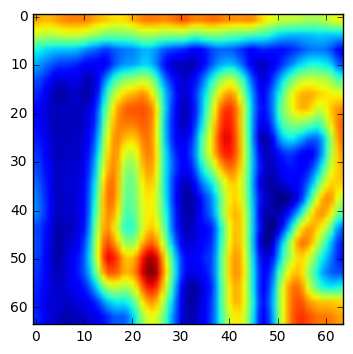

Image label: [ 2  3  7 11 11 11]


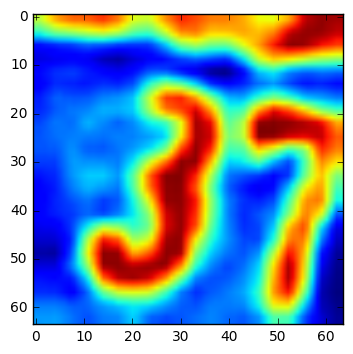

Image label: [ 1  6 11 11 11 11]


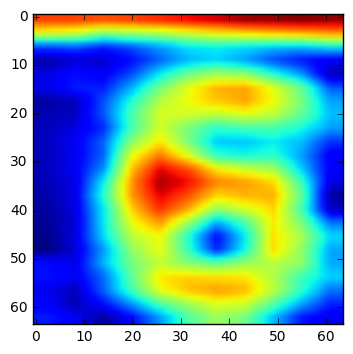

Image label: [ 3  6  5  8 11 11]


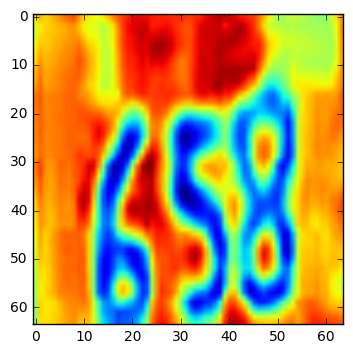

Image label: [ 3  2  8  7 11 11]


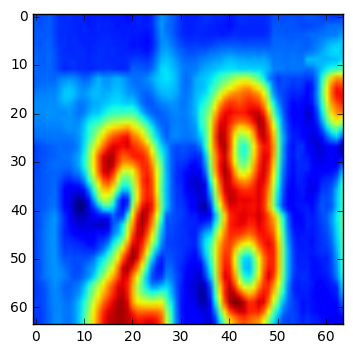

Image label: [ 3  7  6  3 11 11]


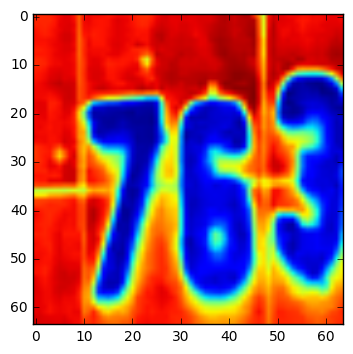

Image label: [ 2  2  8 11 11 11]


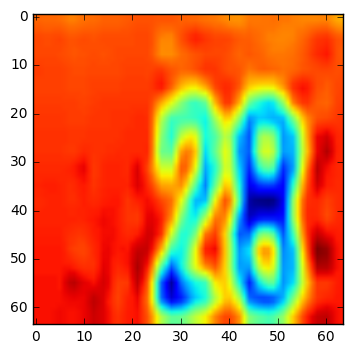

Image label: [ 2  6  2 11 11 11]


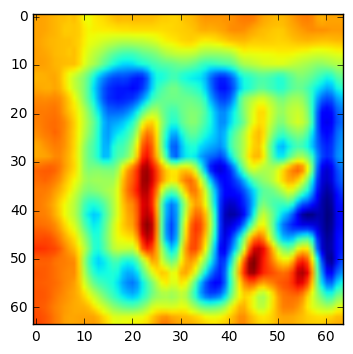

Image label: [ 2  2  1 11 11 11]


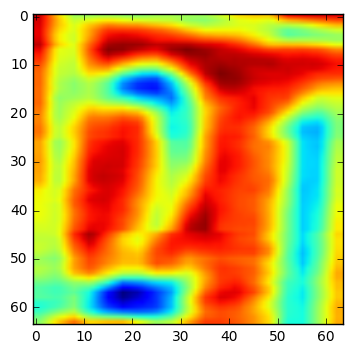

Image label: [ 2  3  0 11 11 11]


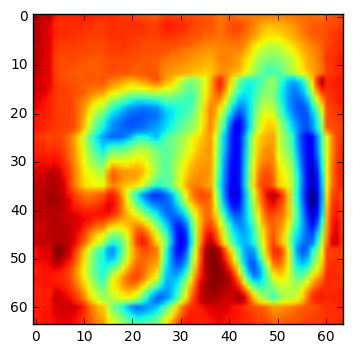

In [25]:
show_imgs(train_dataset, train_labels)

Data shape: (6000, 64, 64)
Image label: [ 3  1  2  7 11 11]


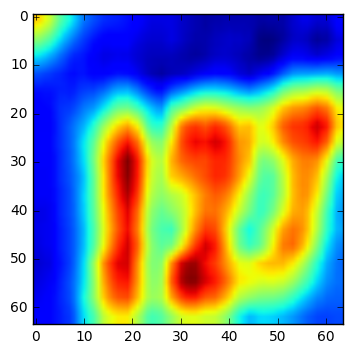

Image label: [ 1  5 11 11 11 11]


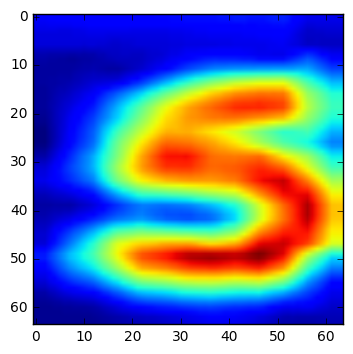

Image label: [ 2  2  0 11 11 11]


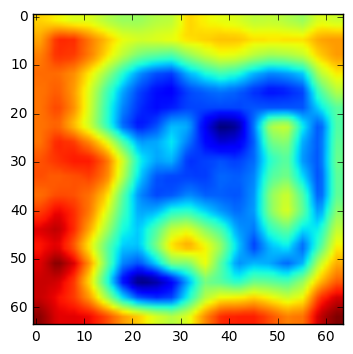

Image label: [ 1  8 11 11 11 11]


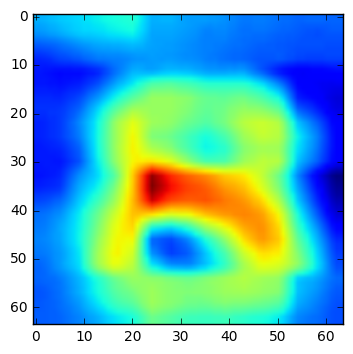

Image label: [ 3  2  3  8 11 11]


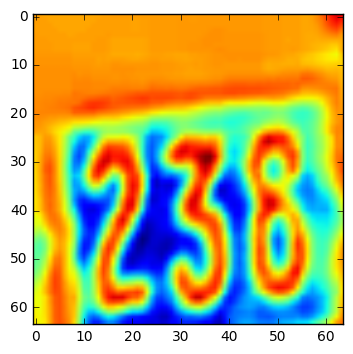

Image label: [ 3  1  1  1 11 11]


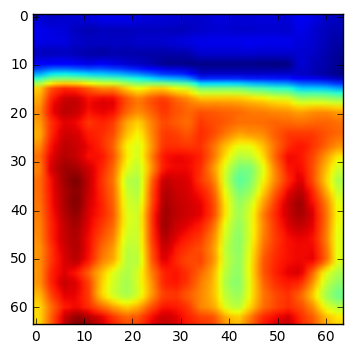

Image label: [ 2  7  0 11 11 11]


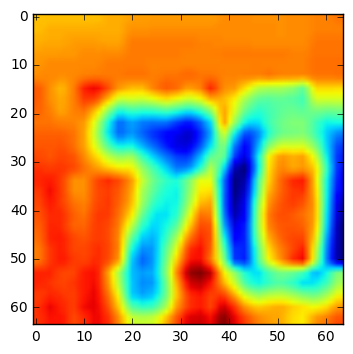

Image label: [ 1  7 11 11 11 11]


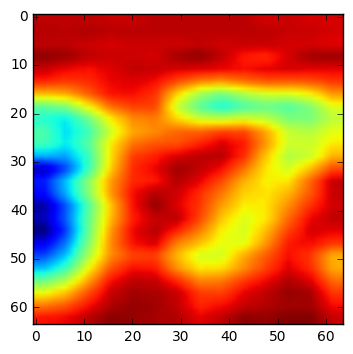

Image label: [ 2  2  1 11 11 11]


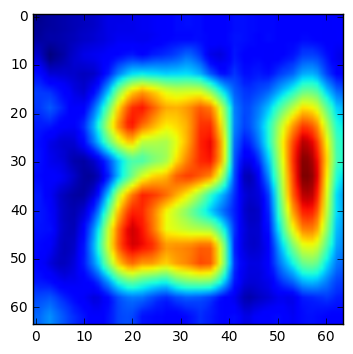

Image label: [ 2  2  2 11 11 11]


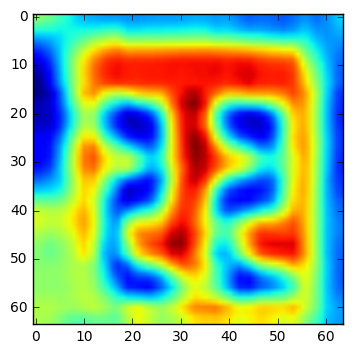

In [26]:
show_imgs(test_dataset, test_labels)

Data shape: (6000, 64, 64)
Image label: [ 2  1  3 11 11 11]


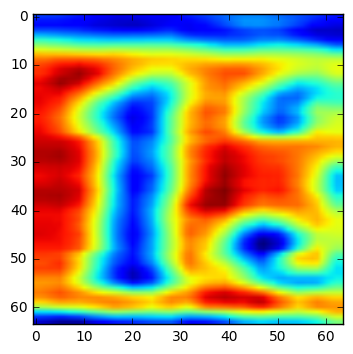

Image label: [ 2  4  4 11 11 11]


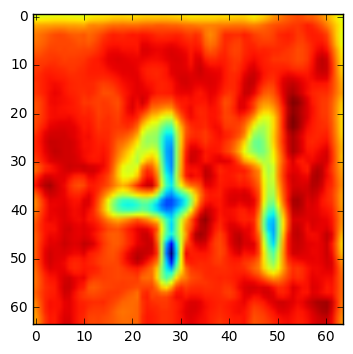

Image label: [ 2  9  5 11 11 11]


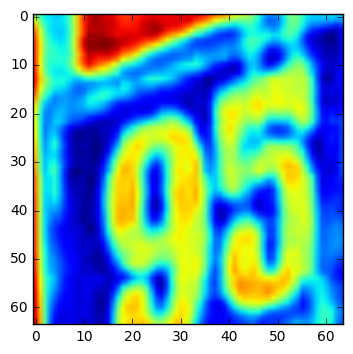

Image label: [ 3  5  5  5 11 11]


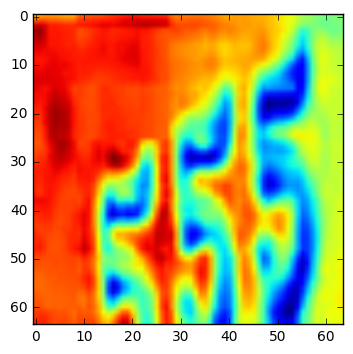

Image label: [ 2  4  3 11 11 11]


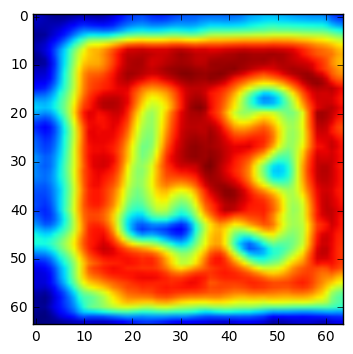

Image label: [ 2  2  6 11 11 11]


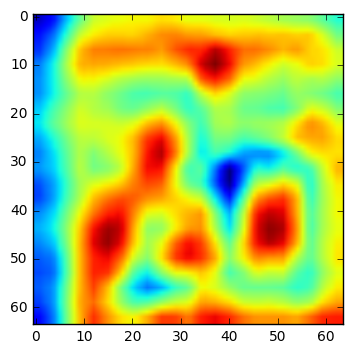

Image label: [ 2  7  7 11 11 11]


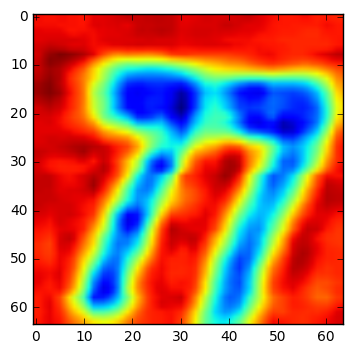

Image label: [ 4  1  2  7  7 11]


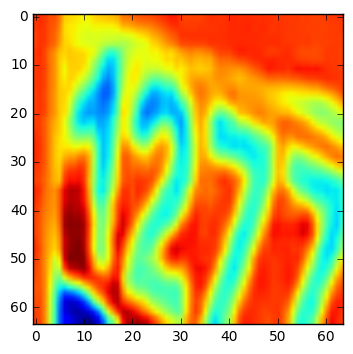

Image label: [ 3  2  8  9 11 11]


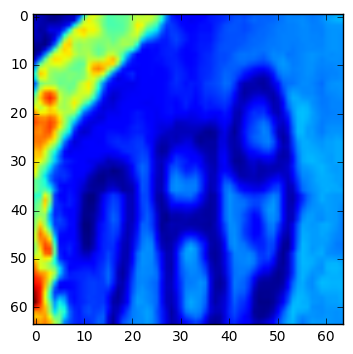

Image label: [ 2  2  9 11 11 11]


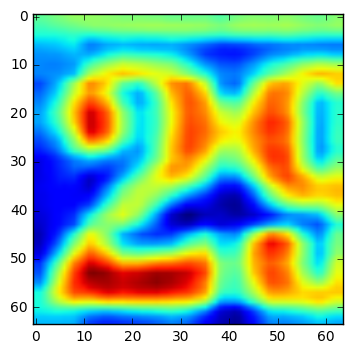

In [27]:
show_imgs(valid_dataset, valid_labels)

In [40]:
# save data as numpy array
filename = "finalData"
ext = ".npy"

currPath = os.getcwd()
path = currPath + "/" + filename
if not os.path.exists(path):
    os.makedirs(path)

def save_data(name, data):
    name = filename + "/" + name + ext
    np.save(name, data)
            
save_data('test_dataset', test_dataset)
save_data('test_labels', test_labels)
save_data('valid_dataset', valid_dataset)
save_data('valid_labels', valid_labels)
save_data('train_dataset', train_dataset)
save_data('train_labels', train_labels)